## Stock Price Prediction by Sentiment Analysis on Financial News



Let's build a model that predicts stock prices based on financial news sentiment. This task normally is an extemely ambitious and sophisticated task, so let's keep it contained to this narrow scope:

Based on the "average" sentiment of the collection of financial news articles within a day, let's predict the movement of SP500 index on the next day.

#### Thinking outloud (the plan):

Let's find a dataset with real financial news articles and historical SP500 stock prices.

Let's create a few features on each article. These could be:
  - a score of how specific the article is to an individual company vs the whole market
  - sentiment on title
  - sentiment on entire article
  - sentiment on first n words
  - sentiment on last n words
  - publication time (after/before/during market open/close)
  - source credibility (or just source)
  - article length
  
Let's create LLM prompts that are specifically fine-tuned for each of these features (some of them can be done without an LLM). Let's have the LLM calculate scores for each. 

Once we have the features, let's train and validate a linear regression model. I don't think a neural network will do well because I don't think there's non-linear correlations between these features.


In [228]:
import polygon
import kagglehub
import glob
import json
from tqdm import tqdm
import pandas as pd
import datetime
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
import os
import yfinance as yf
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
import numpy as np

In [2]:
load_dotenv()

# YOU NEED AN OPENAI API KEY TO RUN THIS UNLESS YOU SKIP THE LLM CALLS
assert os.environ.get("OPENAI_API_KEY") is not None

In [3]:
# Looks like this open source dataset is exactly what we need
# this many articles:
number_of_articles = 306_242 
kaggle_dataset_path = kagglehub.dataset_download("jeet2016/us-financial-news-articles")


In [4]:
data_files = glob.glob(f"{kaggle_dataset_path}/**/*.json")

assert len(data_files) == number_of_articles

In [5]:
# let's see what a single article looks like
with open(data_files[0], 'r') as f:
    article = json.load(f)
article.keys()

dict_keys(['organizations', 'uuid', 'thread', 'author', 'url', 'ord_in_thread', 'title', 'locations', 'entities', 'highlightText', 'language', 'persons', 'text', 'external_links', 'published', 'crawled', 'highlightTitle'])

In [6]:
# looks like there's a lot of unneeded data here
# let's keep these fields:
# we may not need all of these either but it may be helpful to have them for error analysis
keys_we_need = [
    'uuid',
    'author',
    'url',
    'title',
    'text',
    'highlightText',
    'published'
]

article = {key: article[key] for key in keys_we_need}
article

{'uuid': '4e41266ca1707a052245161948413f057982c0b2',
 'author': 'Reuters Editorial',
 'url': 'https://www.reuters.com/article/brief-au-optronics-to-pay-cash-dividend/brief-au-optronics-to-pay-cash-dividend-of-t1-2-share-for-2017-idUSL3N1R953C',
 'title': 'BRIEF-AU Optronics to pay cash dividend of T$1.2/share for 2017',
 'text': 'March 27(Reuters) - AU Optronics Corp :\n* Says it plans to pay cash dividend of T$1.2/share for 2017\nSource text in Chinese: goo.gl/uxuxci\nFurther company coverage: (Beijing Headline News)\n ',
 'highlightText': '',
 'published': '2018-03-27T22:14:00.000+03:00'}

In [7]:
all_data_raw = []
for file in tqdm(data_files):
    with open(file, 'r') as f:
        article = json.load(f)
        article = {key: article[key] for key in keys_we_need}
        all_data_raw.append(article)

  0%|          | 0/306242 [00:00<?, ?it/s]

100%|██████████| 306242/306242 [01:11<00:00, 4260.73it/s]


In [8]:
df = pd.DataFrame(all_data_raw)
df.head()

,uuid,author,url,title,text,highlightText,published
0,4e41266ca1707a052245161948413f057982c0b2,Reuters Editorial,https://www.reuters.com/article/brief-au-optro...,BRIEF-AU Optronics to pay cash dividend of T$1...,March 27(Reuters) - AU Optronics Corp :\n* Say...,,2018-03-27T22:14:00.000+03:00
1,14baef3b7ccb2247669c395093f8080e607696cf,,https://uk.reuters.com/article/uk-britain-econ...,British stats watchdog - stop using RPI inflat...,"March 8, 2018 / 1:35 PM / Updated an hour ago ...",,2018-03-08T15:42:00.000+02:00
2,5265614c8ca52231a35f9008ee5e4313938eb25c,,https://in.reuters.com/video/2018/03/23/dropbo...,Dropbox shares surge in IPO,"Dropbox shares surge in IPO Saturday, March 24...",,2018-03-23T22:23:00.000+03:00
3,8c7842ac387ba659fdcf396582c5041922225324,Reuters Editorial,https://www.reuters.com/article/us-germany-naz...,Bookkeeper of Auschwitz dies before starting s...,BERLIN (Reuters) - The man known as the “bookk...,,2018-03-13T01:05:00.000+02:00
4,b58cb12cc6919413d80a00f9a38b4c22a7142411,Alexandra Gibbs,https://www.cnbc.com/2018/03/05/us-stock-futur...,US stocks set for a negative open as trade war...,Dow closes 336 points higher as trade-war worr...,,2018-03-05T13:27:00.000+02:00


In [9]:
# let's do some initial analysis
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306242 entries, 0 to 306241
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   uuid           306242 non-null  object
 1   author         306242 non-null  object
 2   url            306242 non-null  object
 3   title          306242 non-null  object
 4   text           306242 non-null  object
 5   highlightText  306242 non-null  object
 6   published      306242 non-null  object
dtypes: object(7)
memory usage: 16.4+ MB


In [12]:
# the average article length
print(df['text'].apply(len).mean())

"""
Found this online:

On average, text contains between 5 and 6.5 characters per word including spaces and punctuation.

So 2500 / 5 = 500 words per article
"""


2549.450646874041


'\nFound this online:\n\nOn average, text contains between 5 and 6.5 characters per word including spaces and punctuation.\n\nSo 2500 / 5 = 500 words per article\n'

In [13]:
# average number of words per article
df['text'].apply(len).apply(lambda x: x / 5).describe()

count    306242.000000
mean        509.890129
std         943.923575
min           0.000000
25%          88.400000
50%         280.400000
75%         594.400000
max       43621.600000
Name: text, dtype: float64

In [14]:
# there are articles with 0 words?
df[df['text'].apply(len) == 0]

,uuid,author,url,title,text,highlightText,published
174349,92a16ff47b5c549f4d283f7b944894379b424d0d,Wall Street Journal,https://www.wsj.com/articles/epa-pebble-mine-m...,Letter to the Editor: EPA Pebble Mine Move Is ...,,,2018-02-07T21:51:00.000+02:00


In [15]:
# just a single article, let's remove it
df = df[df['text'].apply(len) > 0]

In [16]:
# let's convert dates to datetime and ET timezone because that's where the market times are based on
df['published'] = pd.to_datetime(df['published'], utc=True).dt.tz_convert('US/Eastern')
df.head()

,uuid,author,url,title,text,highlightText,published
0,4e41266ca1707a052245161948413f057982c0b2,Reuters Editorial,https://www.reuters.com/article/brief-au-optro...,BRIEF-AU Optronics to pay cash dividend of T$1...,March 27(Reuters) - AU Optronics Corp :\n* Say...,,2018-03-27 15:14:00-04:00
1,14baef3b7ccb2247669c395093f8080e607696cf,,https://uk.reuters.com/article/uk-britain-econ...,British stats watchdog - stop using RPI inflat...,"March 8, 2018 / 1:35 PM / Updated an hour ago ...",,2018-03-08 08:42:00-05:00
2,5265614c8ca52231a35f9008ee5e4313938eb25c,,https://in.reuters.com/video/2018/03/23/dropbo...,Dropbox shares surge in IPO,"Dropbox shares surge in IPO Saturday, March 24...",,2018-03-23 15:23:00-04:00
3,8c7842ac387ba659fdcf396582c5041922225324,Reuters Editorial,https://www.reuters.com/article/us-germany-naz...,Bookkeeper of Auschwitz dies before starting s...,BERLIN (Reuters) - The man known as the “bookk...,,2018-03-12 19:05:00-04:00
4,b58cb12cc6919413d80a00f9a38b4c22a7142411,Alexandra Gibbs,https://www.cnbc.com/2018/03/05/us-stock-futur...,US stocks set for a negative open as trade war...,Dow closes 336 points higher as trade-war worr...,,2018-03-05 06:27:00-05:00


In [17]:
"""
Now we need a few LLM prompts for each of the features.
Ideally each feature could be done with an LLM that is fine-tuned for that specific feature.
Also using a separate LLM call for each feature probably eliminates some bias. For example, the sentiment of the title could be influenced by the sentiment of the article.
But I only have $5 of openai credits, so let's just compute them all with one prompt, and just note these improvements for future.
(I could also batch calls but I don't think that'll save on cost because it's the same amount of input and output tokens at the end of the day.)
"""


# Langchain has this extremely nice methodology that takes in pythonic representations and translates them into LLM prompts.
class FinancialSentimentFeatureSet(BaseModel):
    """
    A set of features extracted from a financial news article.
    """

    # These comments below are copied from this langchain tutorial: https://python.langchain.com/docs/tutorials/extraction/

    # ^ Doc-string for the entity Person.
    # This doc-string is sent to the LLM as the description of the schema Person,
    # and it can help to improve extraction results.

    # Note that:
    # 1. Each field is an `optional` -- this allows the model to decline to extract it!
    # 2. Each field has a `description` -- this description is used by the LLM.
    # Having a good description can help improve extraction results.
    specificity_score: int = Field(description="The score of how specific the article is to an individual company vs the whole market. 0 is the least specific, 10 is the most specific")
    relevance_score: int = Field(description="The score of how relevant the article is to the US stock market. A non-US article would not be relevant. 0 is the least relevant, 10 is the most relevant")
    title_sentiment: int = Field(description="The sentiment of the title of the article. 0 is the least positive, 10 is the most positive")
    article_sentiment: int = Field(description="The sentiment of the entire article. 0 is the least positive, 10 is the most positive")
    first_20_words_sentiment: int = Field(description="The sentiment of the first 20 words of the article. 0 is the least positive, 10 is the most positive")
    last_20_words_sentiment: int = Field(description="The sentiment of the last 20 words of the article. 0 is the least positive, 10 is the most positive")

    
    # I've realized by playing with LLMs that making the LLM reason about its own reasoning sometimes results in more accurate computations.
    # Although this may not work well with many features asked all at once. And this is probably a better idea for 
    # chained LLM calls (for example, ask LLM about its reasoning and then ask it to calculate the feature based on that reasoning).
    # For now, let's not use this to save on cost.
    # specificity_score_reasoning: str = Field(description="The reasoning behind the specificity score that was calculated")
    # title_sentiment_reasoning: str = Field(description="The reasoning behind the title sentiment that was calculated")
    # article_sentiment_reasoning: str = Field(description="The reasoning behind the article sentiment that was calculated")
    # first_20_words_sentiment_reasoning: str = Field(description="The reasoning behind the first 20 words sentiment that was calculated")
    # last_20_words_sentiment_reasoning: str = Field(description="The reasoning behind the last 20 words sentiment that was calculated")


In [19]:
random_article = df.sample(1).iloc[0]

# this will give a different article each time
# this is the one I got:
random_article = {'title': 'Voluntary And Conditional Takeover Bid On Vastned Retail Belgium NV Update',
'text': 'April 26 (Reuters) - Vastned Retail Belgium NV:\n* REG-VOLUNTARY AND CONDITIONAL TAKEOVER BID ON VASTNED RETAIL BELGIUM NV: UPDATE\n* ACCEPTANCE BY AT LEAST 90% OF FREE FLOAT IS NECESSARY * ACCEPTANCE PERIOD RUNS FROM 2 MAY 2018 THROUGH 1 JUNE 2018 Source text for Eikon: (Gdynia Newsroom)\n ',}

In [20]:
random_article['title'], random_article['text']

('Voluntary And Conditional Takeover Bid On Vastned Retail Belgium NV Update',
 'April 26 (Reuters) - Vastned Retail Belgium NV:\n* REG-VOLUNTARY AND CONDITIONAL TAKEOVER BID ON VASTNED RETAIL BELGIUM NV: UPDATE\n* ACCEPTANCE BY AT LEAST 90% OF FREE FLOAT IS NECESSARY * ACCEPTANCE PERIOD RUNS FROM 2 MAY 2018 THROUGH 1 JUNE 2018 Source text for Eikon: (Gdynia Newsroom)\n ')

In [60]:
# this is not very accurate but this is a step we should take
example_article_with_features = {
    "title": random_article['title'],
    "text": random_article['text'],
    "relevance_score": 1,
    "specificity_score": 8,
    "title_sentiment": 4,
    "article_sentiment": 6,
    "first_20_words_sentiment": 5,
    "last_20_words_sentiment": 6
}

prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert financial news sentiment analyzer. "
            "You will be given a financial news article and asked to extract a set of features from it. "
            "Focus on accuracy and consistency in your analysis."
            "Here is an example of an article and the features that were extracted from it: {example_article_with_features}."
        ),
        ("human", "{article}"),
    ]
)

In [61]:
llm = ChatOpenAI(model="gpt-4o-mini")
structured_llm = llm.with_structured_output(schema=FinancialSentimentFeatureSet)

def get_feature_set_with_llm(article) -> FinancialSentimentFeatureSet:
    """Make LLM infer financial sentiment features from an article."""
    prompt = prompt_template.invoke({"article": article, "example_article_with_features": example_article_with_features})
    feature_set = structured_llm.invoke(prompt)
    return feature_set

sample_article = df.sample(1).iloc[0]
article = {'title': sample_article['title'], 'text': sample_article['text']}
feature_set = get_feature_set_with_llm(article)


article, feature_set

({'title': 'Last missing Polish miner found dead: JSW',
  'text': 'May 16, 2018 / 5:43 AM / Updated 9 hours ago Last missing Polish miner found dead: JSW Reuters Staff 1 Min Read\nWARSAW (Reuters) - Rescuers searching for Polish miners trapped almost a kilometer underground since a tunnel collapsed 11 days ago have found the body of the last missing man, taking to five the death toll in the incident, coal company JSW said on Wednesday.\nThe Zofiowka mine in southern Poland was hit by an earthquake on May 5, initially trapping seven miners. Two were rescued early last week.\n“The (last) miner’s body was trapped under one of many structures in the destroyed pit,” JSW, the European Union’s biggest coking coal producer, said in a statement.\nAbout 1,000 people were involved in the rescue effort.\nAbout 250 people were working underground at the time of the quake. The missing miners were in a team drilling a new tunnel.\nThe quake of magnitude ranging from 3.5 to 4.0 was the strongest recor

In [23]:
# Let's do this for all articles 
# I'm going to do this with some python parallelization
# See parallel_feature_extraction.py
df.to_json("articles.json", orient="records")


# PROBLEM!!
# ================================================
# Turns out I can only do about 8000 articles with $5 of credits.
# For now, I'll just continue with the 8000 articles in the dataset.
# ================================================

In [37]:
feature_set_files = glob.glob("data/feature_sets/*.json")
len(feature_set_files)

8205

In [38]:
feature_sets_raw = []
for file in tqdm(feature_set_files):
    feature_set = {
        'uuid': file.split('/')[-1].split('.')[0],
    }
    with open(file, 'r') as f:
        feature_set.update(json.load(f))
    feature_sets_raw.append(feature_set)


100%|██████████| 8205/8205 [00:00<00:00, 10117.72it/s]


In [39]:
feature_sets_df = pd.DataFrame(feature_sets_raw)
feature_sets_df.head()

,uuid,specificity_score,relevance_score,title_sentiment,article_sentiment,first_20_words_sentiment,last_20_words_sentiment
0,718282540becfaca342a9aaf96a1175d026d6199,8,10,8,7,8,7
1,13c5257b6ea4776cc914aecca14f3a43cc6ffaeb,8,10,7,6,6,5
2,9e73a7fcbea690dd7c9f765a2dfb2e73bbc6b0d5,7,10,2,3,4,4
3,050c7528c3e59744172ee37b379a5648a6ba3704,8,10,7,6,8,7
4,3065a5915b9fa2cd47ff450d61ea2a328533d247,7,0,3,2,2,3


In [44]:
feature_sets_df.describe()
# nothing that sticks out too much here. The features look pretty evenly distributed.

,specificity_score,relevance_score,title_sentiment,article_sentiment,first_20_words_sentiment,last_20_words_sentiment
count,8205.000000,8205.000000,8205.000000,8205.000000,8205.000000,8205.000000
mean,6.639976,7.567215,5.407434,5.301767,5.539183,5.298477
std,2.158643,4.013115,2.097192,1.915347,2.024913,1.996158
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,8.000000,3.000000,4.000000,4.000000,4.000000
50%,7.000000,10.000000,6.000000,6.000000,6.000000,6.000000
75%,8.000000,10.000000,7.000000,7.000000,7.000000,7.000000
max,10.000000,10.000000,9.000000,9.000000,10.000000,9.000000


In [47]:
df = df.merge(feature_sets_df, on='uuid', how='left')
df.head()


,uuid,author,url,title,text,highlightText,published,specificity_score,relevance_score,title_sentiment,article_sentiment,first_20_words_sentiment,last_20_words_sentiment
0,4e41266ca1707a052245161948413f057982c0b2,Reuters Editorial,https://www.reuters.com/article/brief-au-optro...,BRIEF-AU Optronics to pay cash dividend of T$1...,March 27(Reuters) - AU Optronics Corp :\n* Say...,,2018-03-27 15:14:00-04:00,7.0,10.0,6.0,7.0,8.0,7.0
1,14baef3b7ccb2247669c395093f8080e607696cf,,https://uk.reuters.com/article/uk-britain-econ...,British stats watchdog - stop using RPI inflat...,"March 8, 2018 / 1:35 PM / Updated an hour ago ...",,2018-03-08 08:42:00-05:00,6.0,10.0,2.0,4.0,3.0,4.0
2,5265614c8ca52231a35f9008ee5e4313938eb25c,,https://in.reuters.com/video/2018/03/23/dropbo...,Dropbox shares surge in IPO,"Dropbox shares surge in IPO Saturday, March 24...",,2018-03-23 15:23:00-04:00,8.0,10.0,8.0,9.0,9.0,9.0
3,8c7842ac387ba659fdcf396582c5041922225324,Reuters Editorial,https://www.reuters.com/article/us-germany-naz...,Bookkeeper of Auschwitz dies before starting s...,BERLIN (Reuters) - The man known as the “bookk...,,2018-03-12 19:05:00-04:00,2.0,0.0,3.0,2.0,3.0,2.0
4,b58cb12cc6919413d80a00f9a38b4c22a7142411,Alexandra Gibbs,https://www.cnbc.com/2018/03/05/us-stock-futur...,US stocks set for a negative open as trade war...,Dow closes 336 points higher as trade-war worr...,,2018-03-05 06:27:00-05:00,8.0,10.0,2.0,4.0,3.0,4.0


In [62]:
"""
Now let's calculate these features:
- publication time (after/before/during market open/close)
- source credibility (or just source)
- article length
"""

"\nNow let's calculate these features:\n- publication time (after/before/during market open/close)\n- source credibility (or just source)\n- article length\n"

In [167]:
"""
publication time (after/before/during market open/close)

For this, we could discretize in different ways:
- before market open, during market open, after market close
OR
- each hour of the day gets its own discrete category (1 though 24)

Let's do both and see which one works better in the model.
"""
market_open_time = datetime.datetime(2024, 1, 1, 9, 30, 0, tzinfo=datetime.timezone.utc)
market_close_time = datetime.datetime(2024, 1, 1, 16, 0, 0, tzinfo=datetime.timezone.utc)

def get_publication_period(date: datetime.datetime) -> int:
    """
    Compare the time of the article to the market open and close times and get a discrete category based on that.
    
    before -> -1
    during -> 0
    after -> 1
    """
    global market_open_time, market_close_time

    date_to_compare = date.replace(year=2024, month=1, day=1)

    if date_to_compare < market_open_time:
        return -1
    elif date_to_compare >= market_open_time and date_to_compare < market_close_time:
        return 0
    elif date_to_compare >= market_close_time:
        return 1
    else:
        return None

df['publication_period'] = df['published'].apply(get_publication_period)
df['publication_period_hour'] = df['published'].apply(lambda x: x.hour)

df['publication_period'].value_counts()



publication_period
 1    170009
 0    106445
-1     29787
Name: count, dtype: int64

In [168]:
"""
- source credibility (or just source)

For this one, we can just assign each unique source to a category.
"""


df['author'].value_counts().unique()

# although it seems like not all sources are evenly distributed so this probably won't generalize well.
# let's skip this feature
# in the future, we could build an LLM agent that queries for each source's credibility over the internet

array([126876,  86963,  52528,   1146,    794,    509,    400,    309,
          275,    256,    249,    227,    216,    213,    212,    211,
          207,    205,    190,    185,    184,    176,    173,    172,
          170,    165,    164,    160,    159,    156,    154,    153,
          150,    143,    141,    140,    138,    131,    130,    127,
          124,    123,    120,    116,    115,    113,    112,    111,
          110,    106,    104,    102,    100,     98,     96,     94,
           93,     92,     91,     90,     88,     86,     84,     82,
           81,     80,     79,     78,     77,     76,     74,     73,
           72,     71,     70,     69,     68,     67,     66,     65,
           64,     63,     62,     61,     60,     58,     57,     56,
           55,     54,     53,     52,     50,     49,     48,     47,
           46,     45,     44,     43,     42,     41,     40,     39,
           38,     37,     36,     35,     34,     33,     32,     31,
      

In [73]:
"""
- article length

This is one easy.
"""
df['text_length'] = df['text'].apply(len)
df['text_length'].describe()


count    306241.000000
mean       2549.458972
std        4719.623334
min           1.000000
25%         442.000000
50%        1402.000000
75%        2972.000000
max      218108.000000
Name: text_length, dtype: float64

In [169]:
# let's create a subset for the rows we have features that the LLM computed
df_test = df[df['specificity_score'].notna()]
df_test = df_test.sort_values(by='published')
len(df_test)

8213

In [170]:
# let's make sure there are no NaNs in the test dataset
assert not df_test.isna().any().any()


In [171]:
feature_keys = [
    'publication_period',
    'publication_period_hour',
    'specificity_score',
    'relevance_score',
    'title_sentiment',
    'article_sentiment',
    'first_20_words_sentiment',
    'last_20_words_sentiment',
    'text_length'
]

features = df_test[feature_keys].to_numpy()
features.shape

(8213, 9)

In [160]:
"""
featres -> is our input

Next, let's get some "labels". These will be the change in the SP500 index on the next day.
"""

df_test.published.describe()
# looks like we have articles from 2018-01 to 2018-05


count                                   8213
mean     2018-03-15 11:28:15.188116224-04:00
min                2018-01-29 10:13:00-05:00
25%                2018-03-07 05:00:00-05:00
50%                2018-03-14 16:26:00-04:00
75%                2018-03-25 03:14:00-04:00
max                2018-05-21 02:09:00-04:00
Name: published, dtype: object

In [173]:
start_date = datetime.datetime(2018, 1, 1, 0, 0, 0)
end_date = datetime.datetime(2018, 5, 30, 0, 0, 0)

# Yahoo finance has an unofficial API for this
# SP500's ticker is SPX but apparently for some reason Yahoo finance refers to it as GSPC
sp500 = yf.Ticker("^GSPC")
sp500_history = sp500.history(start=start_date, end=end_date)
sp500_history.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-01-02 00:00:00-05:00,2683.729980,2695.889893,2682.360107,2695.810059,3397430000,0.0,0.0
2018-01-03 00:00:00-05:00,2697.850098,2714.370117,2697.770020,2713.060059,3544030000,0.0,0.0
2018-01-04 00:00:00-05:00,2719.310059,2729.290039,2719.070068,2723.989990,3697340000,0.0,0.0
2018-01-05 00:00:00-05:00,2731.330078,2743.449951,2727.919922,2743.149902,3239280000,0.0,0.0
2018-01-08 00:00:00-05:00,2742.669922,2748.510010,2737.600098,2747.709961,3246160000,0.0,0.0


In [174]:
# Let's use the "Close" column because the closing price is usually the better measure of the stock price on that day
# However, immediately I can see a logical error in our model, where the news in a previous day could affect the stock price on the same previous day, before it has an impact on the next day.

# We want the price delta between today and tomorrow as our actual label. We can't possibly map our features onto an absolute price. But a differential could be feasible.

sp500_history['close_delta'] = sp500_history['Close'].diff()
sp500_history.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,close_delta
Date,,,,,,,,
2018-01-02 00:00:00-05:00,2683.729980,2695.889893,2682.360107,2695.810059,3397430000,0.0,0.0,NaN
2018-01-03 00:00:00-05:00,2697.850098,2714.370117,2697.770020,2713.060059,3544030000,0.0,0.0,17.250000
2018-01-04 00:00:00-05:00,2719.310059,2729.290039,2719.070068,2723.989990,3697340000,0.0,0.0,10.929932
2018-01-05 00:00:00-05:00,2731.330078,2743.449951,2727.919922,2743.149902,3239280000,0.0,0.0,19.159912
2018-01-08 00:00:00-05:00,2742.669922,2748.510010,2737.600098,2747.709961,3246160000,0.0,0.0,4.560059


In [175]:


# Each row's label will be the price on the next day of the publication date
# BUT there are weekends and market-off days. For these cases, we want to find the next market-on day.
sp500_history.index = sp500_history.index.tz_convert('US/Eastern')

df_test = pd.merge_asof(
    df_test, 
    sp500_history.shift(-1)[['close_delta']], # this will shift the price delta of tomorrow to today
    left_on='published', 
    right_index=True,
    direction='forward' # this will make the merge go in the forward direction to find the next market-on day
)

In [176]:
df_test.head()

,uuid,author,url,title,text,highlightText,published,specificity_score,relevance_score,title_sentiment,article_sentiment,first_20_words_sentiment,last_20_words_sentiment,publication_period,publication_period_hour,text_length,close_delta
192675,9f8a2ca8c96da5a643611269a1711a51e6261445,Hollie Wong,https://www.cnbc.com/2018/01/29/davos-2018-why...,Davos 2018: Why Will.i.am isn’t afraid of arti...,Some billionaires in the tech world have aired...,,2018-01-29 10:13:00-05:00,5.0,0.0,7.0,8.0,8.0,7.0,0,10,2672,1.380127
4906,9f8a2ca8c96da5a643611269a1711a51e6261445,Hollie Wong,https://www.cnbc.com/2018/01/29/davos-2018-why...,Davos 2018: Why Will.i.am isn’t afraid of arti...,Some billionaires in the tech world have aired...,,2018-01-29 10:13:00-05:00,5.0,0.0,7.0,8.0,8.0,7.0,0,10,2672,1.380127
227118,14b5cbe90535d490188f8210286519bd919d191e,Michelle Castillo,https://www.cnbc.com/2018/01/29/what-is-5g.html,What is 5G?,CNBC.com Gustau Nacarino | Reuters An SK telec...,,2018-01-29 14:22:00-05:00,7.0,8.0,6.0,5.0,7.0,4.0,1,14,4234,1.380127
129550,09c0000e73875e4eee0639d19a80c20b5ccd7123,,https://www.reuters.com/article/us-column-mill...,"For some, traumatic life jolts lead to profoun...","February 22, 2018 / 12:12 PM / Updated 9 hours...",,2018-02-22 07:09:00-05:00,5.0,0.0,7.0,5.0,6.0,4.0,0,7,5711,32.300049
4069,09c0000e73875e4eee0639d19a80c20b5ccd7123,Reuters Editorial,https://www.reuters.com/article/us-column-mill...,"For some, traumatic life jolts lead to profoun...",CHICAGO (Reuters) - (The opinions expressed he...,,2018-02-22 12:12:00-05:00,5.0,0.0,7.0,5.0,6.0,4.0,1,12,5589,32.300049


<Axes: xlabel='published_day'>

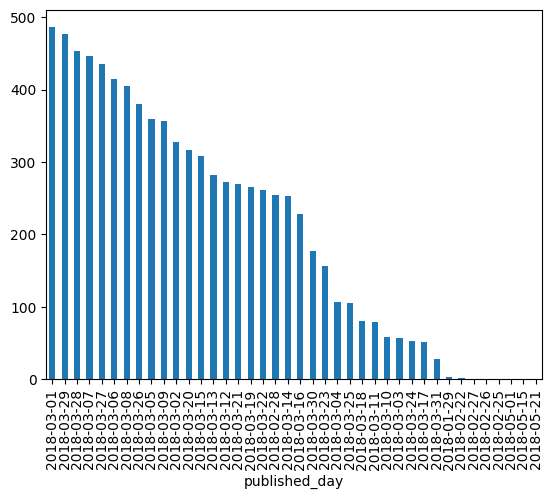

In [184]:
"""
Now as we said in the beginning, we want to compute the average of all features of articles from the same day. This is the premise of our model.

The metric could also be any of the min, max, median, std, mode, median, sum, etc. of the features. It doesn't have to be the mean.
"""

df_test['published_day'] = df_test['published'].dt.date
df_test['published_day'].value_counts().plot(kind='bar')
# We don't seem to have a very even distribution of days but this is due to the fact that we're only using 8000 articles out of 350k.
# I should've sampled evenly at the beginning, but I'm already out of LLM credits.
# Let's keep writing the code and once all the data is processed, this code can be run again.


In [191]:
# compute the mean features (the label will stay the same - average over idential values)
model_df = df_test.groupby('published_day')[feature_keys + ['close_delta']].mean()
model_df.head()

# now we have all our model inputs and outputs ready in model_df

,publication_period,publication_period_hour,specificity_score,relevance_score,title_sentiment,article_sentiment,first_20_words_sentiment,last_20_words_sentiment,text_length,close_delta
published_day,,,,,,,,,,
2018-01-29,0.333333,11.333333,5.666667,2.666667,6.666667,7.0,7.666667,6.0,3192.666667,1.380127
2018-02-22,0.500000,9.500000,5.000000,0.000000,7.000000,5.0,6.000000,4.0,5650.000000,32.300049
2018-02-25,1.000000,19.000000,7.000000,10.000000,8.000000,6.0,7.000000,5.0,190.000000,-35.320068
2018-02-26,1.000000,17.000000,8.000000,0.000000,7.000000,6.0,6.000000,7.0,3539.000000,-30.449951
2018-02-27,1.000000,19.000000,0.000000,0.000000,7.000000,6.0,6.000000,5.0,99.000000,-36.160156


In [194]:
# BIG PROBLEM!!
# ================================================
# We have 40 rows of data for 9 features. This is not going to be a good model for now!
# We probably need at least a few hundred days of data. But let's keep going for now. We could eliminate some features.
# ================================================
len(model_df), len(feature_keys)


(40, 9)

In [211]:
# Time for the linear regression model
train_df, test_df = train_test_split(model_df, test_size=0.2, random_state=18)

model = LinearRegression()
model.fit(train_df[feature_keys], train_df['close_delta'])

model.score(test_df[feature_keys], test_df['close_delta'])

# This does not look like a good model at all.

0.040215225987522696

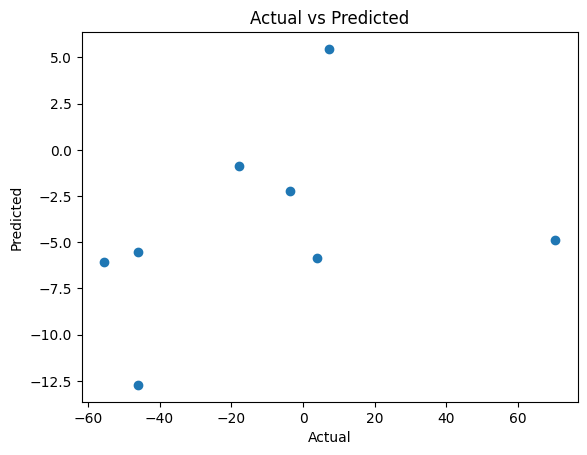

In [212]:
plt.scatter(test_df['close_delta'], model.predict(test_df[feature_keys]))
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [222]:
# I think the plot could signify that we can't accurately infer the delta BUT
# looks like we could possibly infer the direction of the delta.
# As in -> does the stock go up or down?
# Let's validate this hypothesis.

model_df['close_delta_direction'] = model_df['close_delta'].apply(lambda x: 1 if x > 0 else 0)
model_df.head()

,publication_period,publication_period_hour,specificity_score,relevance_score,title_sentiment,article_sentiment,first_20_words_sentiment,last_20_words_sentiment,text_length,close_delta,close_delta_direction
published_day,,,,,,,,,,,
2018-01-29,0.333333,11.333333,5.666667,2.666667,6.666667,7.0,7.666667,6.0,3192.666667,1.380127,1
2018-02-22,0.500000,9.500000,5.000000,0.000000,7.000000,5.0,6.000000,4.0,5650.000000,32.300049,1
2018-02-25,1.000000,19.000000,7.000000,10.000000,8.000000,6.0,7.000000,5.0,190.000000,-35.320068,0
2018-02-26,1.000000,17.000000,8.000000,0.000000,7.000000,6.0,6.000000,7.0,3539.000000,-30.449951,0
2018-02-27,1.000000,19.000000,0.000000,0.000000,7.000000,6.0,6.000000,5.0,99.000000,-36.160156,0


In [226]:
# we need a logistic regression model for this
train_df, test_df = train_test_split(model_df, test_size=0.2, random_state=54)

model = LogisticRegression()
model.fit(train_df[feature_keys], train_df['close_delta_direction'])
model.score(test_df[feature_keys], test_df['close_delta_direction'])

# looks like this model is slightly better.


/Users/sarpertt/personal/within-test/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.625

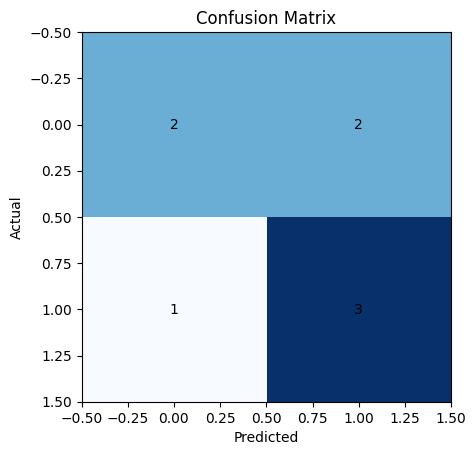

In [231]:
# confusion matrix
confusion_matrix(test_df['close_delta_direction'], model.predict(test_df[feature_keys]))
cm = confusion_matrix(test_df['close_delta_direction'], model.predict(test_df[feature_keys]))
plt.imshow(cm, cmap='Blues')
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# with this small amount of test data, it's very hard to say but at least the hypothesis is not disproved.


## Conclusion

Seems like I have a few problems to deal with:
- I don't have enough LLM credits and time to get sentiment features for all articles
- The underlying premise of the model is slightly flawed. The market is probably reacting to the news as they come out.

Next steps:
- Validate that the news data is representative all the data sources market participants use
- Validate that the features computed by the LLM are actually good
- Compute features for more articles
- Do error analysis
  - Look at predictions with very high and very low confidence
    - I'd expect to see clear patterns here. This can possibly expose limitations on the sentiment features we compute. Or it could expose that some of the features are unneeded or even steering the model in the wrong direction.



